In [236]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

%matplotlib inline

In [237]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [238]:
import pandas as pd

#Read input data
df_train = pd.read_csv('/content/drive/MyDrive/ML/titanic-ml-project/data/raw/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/ML/titanic-ml-project/data/raw/test.csv')

df_train['Data_Split'] = 'train'
df_test['Data_Split'] = 'test'
df = pd.concat([df_train, df_test])


In [239]:
#Display first 20 rows
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Data_Split
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,train
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,train
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,train
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,train
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,train


### Feature Engineering

In [240]:
#Creating new family_size column
df['Family_Size']=df['SibSp']+df['Parch']
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Data_Split,Family_Size
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test,0
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test,0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test,0
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test,0


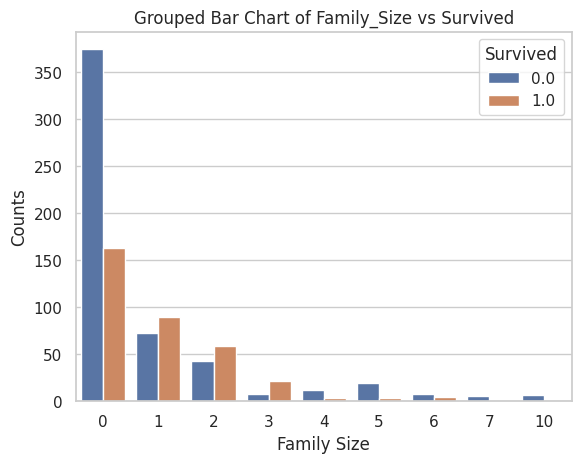

In [241]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each combination of Family_Size and Survived
count_df = df.groupby(['Family_Size', 'Survived']).size().reset_index(name='Counts')

# Grouped Bar Chart
sns.barplot(x='Family_Size', y='Counts', hue='Survived', data=count_df)
plt.title('Grouped Bar Chart of Family_Size vs Survived')
plt.xlabel('Family Size')
plt.ylabel('Counts')
plt.show()


In [242]:
value_counts = df['Family_Size'].value_counts()
print(value_counts)

Family_Size
0     790
1     235
2     159
3      43
5      25
4      22
6      16
10     11
7       8
Name: count, dtype: int64


In [243]:
df['Fare_Per_Person']=round(df['Fare']/(df['Family_Size']+1), 1)


In [244]:
# Define the bins and labels
bins = [-1, 0, 3, 10]  # Bins for the categories
labels = ['A', 'B', 'C']  # Corresponding labels for the bins

# Create a new column 'Category' based on the bins
df['Family_Size_Class'] = pd.cut(df['Family_Size'], bins=bins, labels=labels)

In [245]:
df = df.drop('Family_Size', axis=1)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Data_Split,Fare_Per_Person,Family_Size_Class
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,3.6,B
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,35.6,B
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,7.9,A
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,26.6,B
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,8.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test,8.0,A
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test,108.9,A
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test,7.2,A
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test,8.0,A


In [246]:
# Replace NaN with 0 and other values with 1
df['Cabin'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

print(df)

     PassengerId  Survived  Pclass  \
0              1       0.0       3   
1              2       1.0       1   
2              3       1.0       3   
3              4       1.0       1   
4              5       0.0       3   
..           ...       ...     ...   
413         1305       NaN       3   
414         1306       NaN       1   
415         1307       NaN       3   
416         1308       NaN       3   
417         1309       NaN       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

In [247]:
value_counts = df['Cabin'].value_counts()
print(value_counts)

Cabin
0    1014
1     295
Name: count, dtype: int64


In [248]:
# Dropping columns
columns_to_drop = ['Name','SibSp','Fare','PassengerId','Ticket', 'Parch']
df = df.drop(columns=columns_to_drop)
df

,Survived,Pclass,Sex,Age,Cabin,Embarked,Data_Split,Fare_Per_Person,Family_Size_Class
0,0.0,3,male,22.0,0,S,train,3.6,B
1,1.0,1,female,38.0,1,C,train,35.6,B
2,1.0,3,female,26.0,0,S,train,7.9,A
3,1.0,1,female,35.0,1,S,train,26.6,B
4,0.0,3,male,35.0,0,S,train,8.0,A
...,...,...,...,...,...,...,...,...,...
413,NaN,3,male,NaN,0,S,test,8.0,A
414,NaN,1,female,39.0,1,C,test,108.9,A
415,NaN,3,male,38.5,0,S,test,7.2,A
416,NaN,3,male,NaN,0,S,test,8.0,A


In [249]:
# Check the data types
print(df.dtypes)

Survived              float64
Pclass                  int64
Sex                    object
Age                   float64
Cabin                   int64
Embarked               object
Data_Split             object
Fare_Per_Person       float64
Family_Size_Class    category
dtype: object


#### Data Split

In [252]:
# Split the data
train_data = df[df['Data_Split'] == 'train']
test_data = df[df['Data_Split'] == 'test']

# Remove the empty column "Survived" that was added to the test data
test_data = test_data.drop('Survived', axis=1)

### Null values

In [253]:
#Find the shape of the dataset
train_data.shape

(891, 9)

In [254]:
#Find the proportion of missing values in the dataset
for i in train_data.columns:
    missing_val_percent = train_data[i].isnull().sum()/train_data.shape[0]
    print(f"Missing values in the column {i}: {missing_val_percent}")

Missing values in the column Survived: 0.0
Missing values in the column Pclass: 0.0
Missing values in the column Sex: 0.0
Missing values in the column Age: 0.19865319865319866
Missing values in the column Cabin: 0.0
Missing values in the column Embarked: 0.002244668911335578
Missing values in the column Data_Split: 0.0
Missing values in the column Fare_Per_Person: 0.0
Missing values in the column Family_Size_Class: 0.0


In [255]:
train_data.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
Cabin,0
Embarked,2
Data_Split,0
Fare_Per_Person,0
Family_Size_Class,0


In [256]:
# Use mode imputation to fill the missing values in Embarked column
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])

/tmp/ipython-input-3800542149.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])


In [257]:
# Impute missing values with the median
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())

/tmp/ipython-input-1986879714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())


In [258]:
#Provide information about the dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Survived           891 non-null    float64 
 1   Pclass             891 non-null    int64   
 2   Sex                891 non-null    object  
 3   Age                891 non-null    float64 
 4   Cabin              891 non-null    int64   
 5   Embarked           891 non-null    object  
 6   Data_Split         891 non-null    object  
 7   Fare_Per_Person    891 non-null    float64 
 8   Family_Size_Class  891 non-null    category
dtypes: category(1), float64(3), int64(2), object(3)
memory usage: 63.6+ KB


In [259]:
train_data.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
Cabin,0
Embarked,0
Data_Split,0
Fare_Per_Person,0
Family_Size_Class,0


### More plots

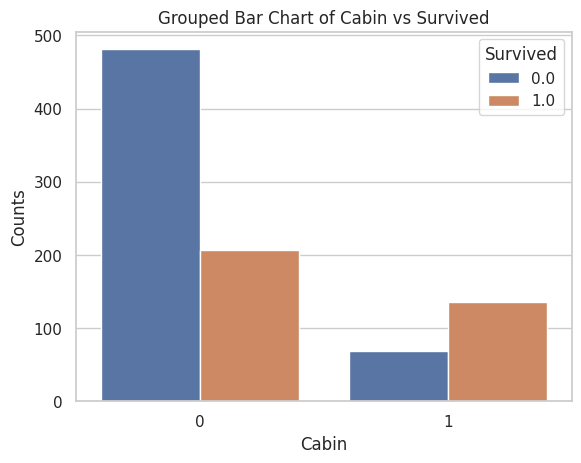

In [260]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each combination of Cabin and Survived
count_train_data = train_data.groupby(['Cabin', 'Survived']).size().reset_index(name='Counts')

# Grouped Bar Chart
sns.barplot(x='Cabin', y='Counts', hue='Survived', data=count_train_data)
plt.title('Grouped Bar Chart of Cabin vs Survived')
plt.xlabel('Cabin')
plt.ylabel('Counts')
plt.show()


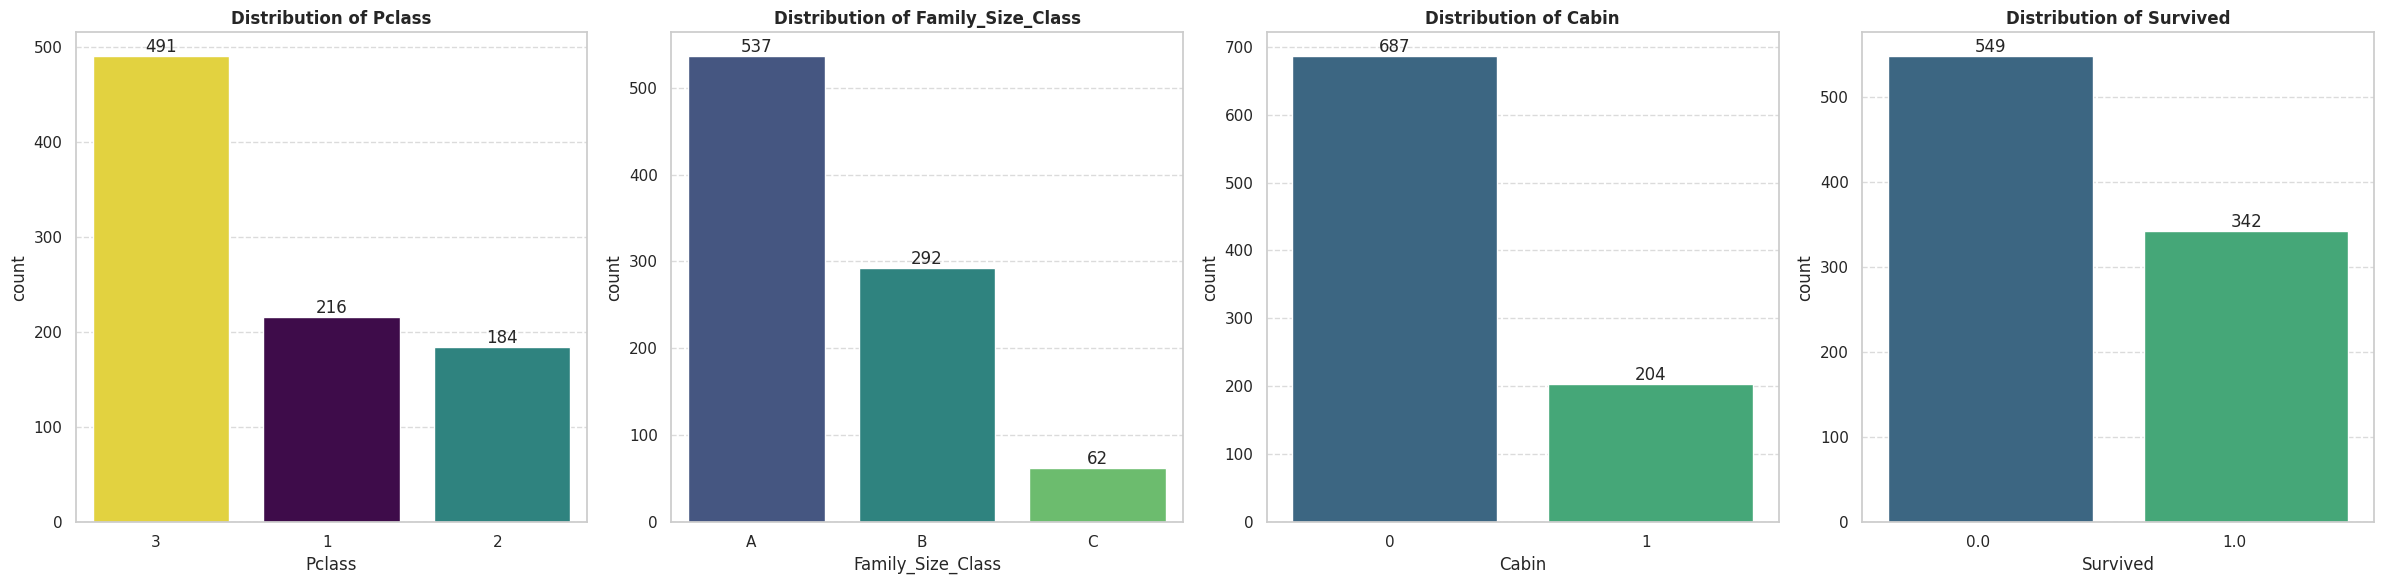

In [261]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create figure with specific size for readability
plt.figure(figsize=(24, 6))

# Columns to visualize
categorical_columns = ['Pclass', 'Family_Size_Class', 'Cabin', 'Survived']

# Create 1x4 grid of charts
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(1, 4, i)

    # Updated countplot to resolve FutureWarning
    chart = sns.countplot(
        data=train_data,
        x=column,
        hue=column,  # Assign x to hue
        legend=False,  # Remove legend
        order=train_data[column].value_counts().index,
        palette='viridis'  # Color palette
    )

    # Rotate and align the tick labels
    plt.xticks(rotation=0, ha='right')

    # Add title and adjust font
    plt.title(f'Distribution of {column}', fontsize=12, fontweight='bold')

    # Add count labels
    for container in chart.containers:
        chart.bar_label(container, label_type='edge')

    # Add grid lines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure tight layout to prevent overlap
plt.tight_layout()
plt.show()


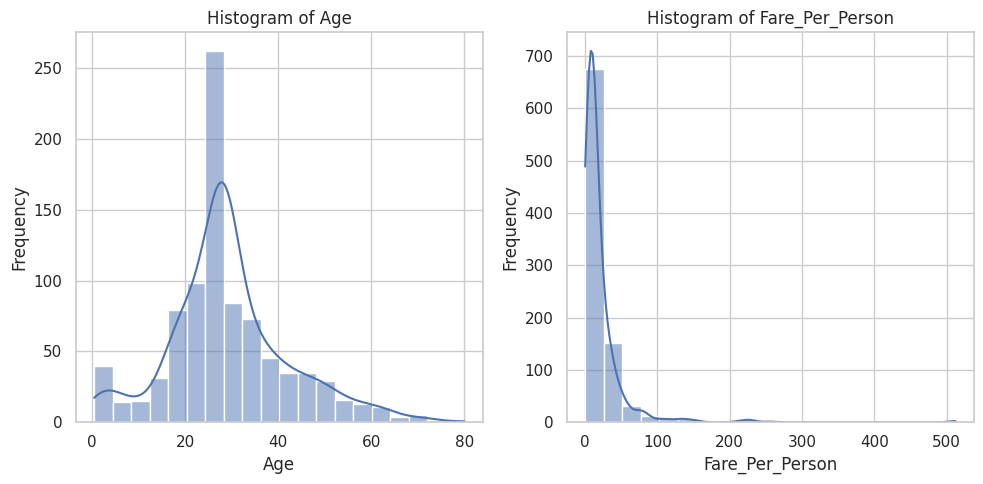

In [262]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the names of the columns you want to plot
columns_to_plot = ['Age', 'Fare_Per_Person']
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure with subplots
plt.figure(figsize=(10, 5))  # Adjusted width for better visibility in a horizontal layout

# Plot histograms for each specified column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 2, i)  # Create a 1x5 grid of subplots
    sns.histplot(train_data[column], bins=20, kde=True)  # kde=True adds a kernel density estimate
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')



# Adjust layout
plt.tight_layout()
plt.show()

### Outliers

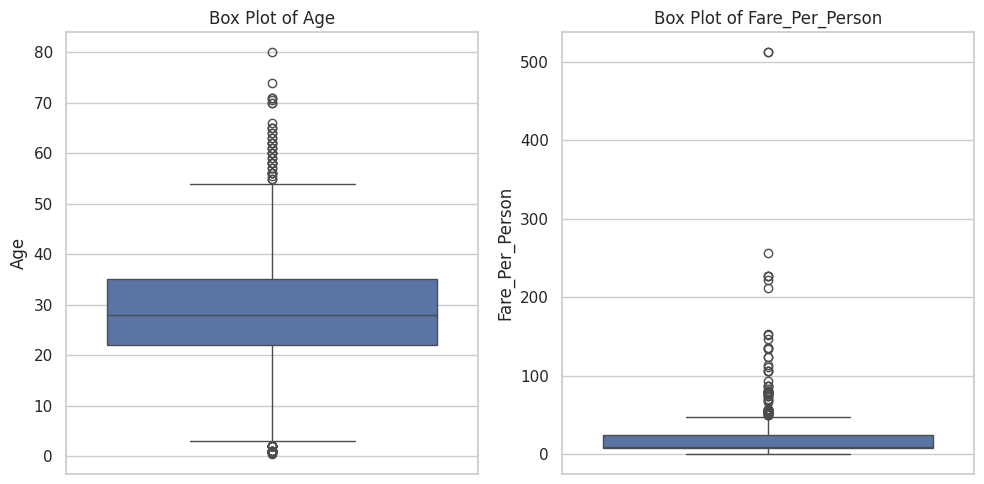

In [263]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the names of the columns you want to plot
columns_to_plot = ['Age', 'Fare_Per_Person']
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure with subplots
plt.figure(figsize=(10, 5))  # Adjusted width for better visibility in a horizontal layout

# Plot box plots for each specified column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 2, i)  # Create a 1x5 grid of subplots
    sns.boxplot(data=train_data, y=column)  # Use y=column for vertical box plots
    plt.title(f'Box Plot of {column}')
    plt.ylabel(column)

# Adjust layout
plt.tight_layout()
plt.show()


In [264]:
train_data['Age'].unique()

array([22.  , 38.  , 26.  , 35.  , 28.  , 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  ,  8.  ,
       19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  , 49.  ,
       29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  , 16.  ,
       25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  , 71.  ,
       37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 , 51.  ,
       55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  , 45.5 ,
       20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  , 60.  ,
       10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  , 70.  ,
       24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [265]:
from scipy import stats

# Calculate Z-scores
train_data['Z-score_Age'] = stats.zscore(train_data['Age'])

# Define outliers based on Z-score threshold
outlier_condition = (train_data['Z-score_Age'] > 3) | (train_data['Z-score_Age'] < -3)
outliers = train_data[outlier_condition]

# Sort the outliers in ascending order and print only the outlier values of Age and their Z-scores
sorted_outliers = outliers[['Age', 'Z-score_Age']].sort_values(by='Age')
print(sorted_outliers)

      Age  Z-score_Age
745  70.0     3.123056
672  70.0     3.123056
116  70.5     3.161481
96   71.0     3.199906
493  71.0     3.199906
851  74.0     3.430455
630  80.0     3.891554


/tmp/ipython-input-3336135272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Z-score_Age'] = stats.zscore(train_data['Age'])


In [266]:
# Define the threshold for outliers (Custom partial removal of outlier based on Z-score)
threshold = 3.19

# Calculate the median of the Age column
median_value = train_data['Age'].median()

# Replace outliers with the median
train_data.loc[train_data['Z-score_Age'] > threshold, 'Age'] = median_value

In [267]:
train_data = train_data.drop('Z-score_Age', axis=1)

Text(0.5, 1.0, 'Boxplot for Age')

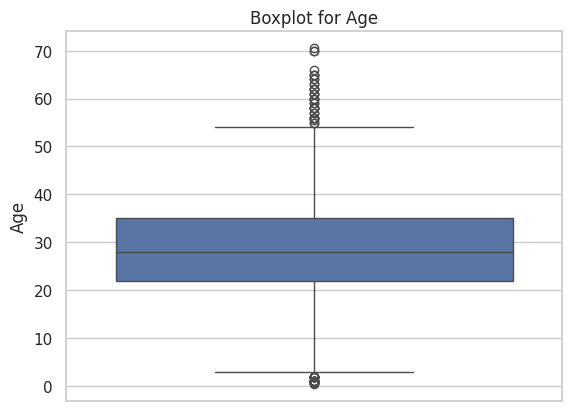

In [268]:
#Find outliers in the age column using box plot
sb.boxplot(train_data['Age'])
plt.title('Boxplot for Age')

In [269]:
from scipy import stats

# Calculate Z-scores
train_data['Z-score_Fare'] = stats.zscore(train_data['Fare_Per_Person'])

# Define outliers based on Z-score threshold
outlier_condition = (train_data['Z-score_Fare'] > 3) | (train_data['Z-score_Fare'] < -3)
outliers = train_data[outlier_condition]

# Sort the outliers in ascending order and print only the outlier values of Fare_Per_Person and their Z-scores
sorted_outliers = outliers[['Fare_Per_Person', 'Z-score_Fare']].sort_values(by='Fare_Per_Person')
print(sorted_outliers)


     Fare_Per_Person  Z-score_Fare
337            134.5      3.198774
325            135.6      3.229482
373            135.6      3.229482
269            135.6      3.229482
195            146.5      3.533771
708            151.6      3.676145
609            153.5      3.729186
730            211.3      5.342757
527            221.8      5.635880
380            227.5      5.795003
716            227.5      5.795003
557            227.5      5.795003
679            256.2      6.596205
258            512.3     13.745608
737            512.3     13.745608


In [270]:
# Define the threshold for outliers (Custom partial removal of outlier based on Z-score)
threshold = 5.34

# Calculate the median of the Fare_Per_Person column
median_value = train_data['Fare_Per_Person'].median()

# Replace outliers with the median
train_data.loc[train_data['Z-score_Fare'] > threshold, 'Fare_Per_Person'] = median_value


In [271]:
train_data = train_data.drop('Z-score_Fare', axis=1)

Text(0.5, 1.0, 'Box Plot for Fare')

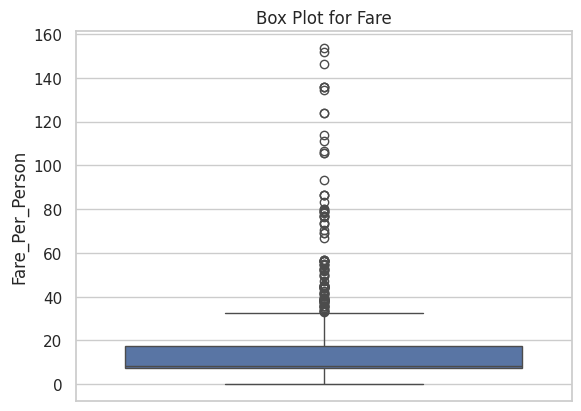

In [272]:
#Find if Fare has any outliers
sb.boxplot(train_data['Fare_Per_Person'])
plt.title('Box Plot for Fare')

In [273]:
train_data.drop('Survived', axis=1, inplace=True)
train_data

,Pclass,Sex,Age,Cabin,Embarked,Data_Split,Fare_Per_Person,Family_Size_Class
0,3,male,22.0,0,S,train,3.6,B
1,1,female,38.0,1,C,train,35.6,B
2,3,female,26.0,0,S,train,7.9,A
3,1,female,35.0,1,S,train,26.6,B
4,3,male,35.0,0,S,train,8.0,A
...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,S,train,13.0,A
887,1,female,19.0,1,S,train,30.0,A
888,3,female,28.0,0,S,train,5.9,B
889,1,male,26.0,1,C,train,30.0,A


### Joining data before encoding

In [274]:
df = pd.concat([train_data, test_data])
df

,Pclass,Sex,Age,Cabin,Embarked,Data_Split,Fare_Per_Person,Family_Size_Class
0,3,male,22.0,0,S,train,3.6,B
1,1,female,38.0,1,C,train,35.6,B
2,3,female,26.0,0,S,train,7.9,A
3,1,female,35.0,1,S,train,26.6,B
4,3,male,35.0,0,S,train,8.0,A
...,...,...,...,...,...,...,...,...
413,3,male,NaN,0,S,test,8.0,A
414,1,female,39.0,1,C,test,108.9,A
415,3,male,38.5,0,S,test,7.2,A
416,3,male,NaN,0,S,test,8.0,A


### Encoding

In [275]:
from sklearn.preprocessing import LabelEncoder

#Perform label encoding on Sex column
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])

In [276]:
value_counts = df['Embarked'].value_counts()
print(value_counts)

Embarked
S    916
C    270
Q    123
Name: count, dtype: int64


In [277]:
value_counts = df['Family_Size_Class'].value_counts()
print(value_counts)

Family_Size_Class
A    790
B    437
C     82
Name: count, dtype: int64


In [278]:
#Perform one-hot encoding on Embarked column
embarked_enc = pd.get_dummies(df['Embarked']).astype(int)
family_fize_class_enc = pd.get_dummies(df['Family_Size_Class']).astype(int)

In [279]:
embarked_enc_drop = pd.get_dummies(df['Embarked'], drop_first=True)
family_fize_class_enc_drop = pd.get_dummies(df['Family_Size_Class'], drop_first=True)

In [280]:
data_encoded = pd.concat([df, embarked_enc, family_fize_class_enc], axis=1)
data_encoded.head(10)

,Pclass,Sex,Age,Cabin,Embarked,Data_Split,Fare_Per_Person,Family_Size_Class,C,Q,S,A,B,C
0,3,1,22.0,0,S,train,3.6,B,0,0,1,0,1,0
1,1,0,38.0,1,C,train,35.6,B,1,0,0,0,1,0
2,3,0,26.0,0,S,train,7.9,A,0,0,1,1,0,0
3,1,0,35.0,1,S,train,26.6,B,0,0,1,0,1,0
4,3,1,35.0,0,S,train,8.0,A,0,0,1,1,0,0
5,3,1,28.0,0,Q,train,8.5,A,0,1,0,1,0,0
6,1,1,54.0,1,S,train,51.9,A,0,0,1,1,0,0
7,3,1,2.0,0,S,train,4.2,C,0,0,1,0,0,1
8,3,0,27.0,0,S,train,3.7,B,0,0,1,0,1,0
9,2,0,14.0,0,C,train,15.0,B,1,0,0,0,1,0


In [281]:
data_encoded.drop('Embarked', axis=1, inplace=True)
data_encoded.drop('Family_Size_Class', axis=1, inplace=True)
data_encoded

,Pclass,Sex,Age,Cabin,Data_Split,Fare_Per_Person,C,Q,S,A,B,C
0,3,1,22.0,0,train,3.6,0,0,1,0,1,0
1,1,0,38.0,1,train,35.6,1,0,0,0,1,0
2,3,0,26.0,0,train,7.9,0,0,1,1,0,0
3,1,0,35.0,1,train,26.6,0,0,1,0,1,0
4,3,1,35.0,0,train,8.0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,NaN,0,test,8.0,0,0,1,1,0,0
414,1,0,39.0,1,test,108.9,1,0,0,1,0,0
415,3,1,38.5,0,test,7.2,0,0,1,1,0,0
416,3,1,NaN,0,test,8.0,0,0,1,1,0,0


In [282]:
# Use descriptive statistics to find the min and max values
data_encoded.describe()

,Pclass,Sex,Age,Cabin,Fare_Per_Person,C,Q,S,A,B,C
count,1309.000000,1309.000000,1223.000000,1309.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,0.644003,29.458438,0.225363,18.737309,0.206264,0.093965,0.699771,0.603514,0.333843,0.062643
std,0.837836,0.478997,13.099130,0.417981,26.604900,0.404777,0.291891,0.458533,0.489354,0.471765,0.242413
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,22.000000,0.000000,7.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,28.000000,0.000000,8.300000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,3.000000,1.000000,36.000000,0.000000,21.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,3.000000,1.000000,76.000000,1.000000,262.400000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Data Split

In [283]:
# Split the data
X_train = data_encoded[data_encoded['Data_Split'] == 'train']
X_train.drop('Data_Split', axis=1, inplace=True)

X_test = data_encoded[data_encoded['Data_Split'] == 'test']
X_test.drop('Data_Split', axis=1, inplace=True)

/tmp/ipython-input-3092690611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop('Data_Split', axis=1, inplace=True)
/tmp/ipython-input-3092690611.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('Data_Split', axis=1, inplace=True)


## Scaling

In [284]:
### Perform Robust Scaling to handle outliers
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()
columns_to_scale = ['Age', 'Fare_Per_Person']

# Fit and transform the training data
X_train[columns_to_scale] = rob_scaler.fit_transform(X_train[columns_to_scale])

# Transform the test data
X_test[columns_to_scale] = rob_scaler.fit_transform(X_test[columns_to_scale])

X_train

/tmp/ipython-input-698201191.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[columns_to_scale] = rob_scaler.fit_transform(X_train[columns_to_scale])
/tmp/ipython-input-698201191.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columns_to_scale] = rob_scaler.fit_transform(X_test[columns_to_scale])


,Pclass,Sex,Age,Cabin,Fare_Per_Person,C,Q,S,A,B,C
0,3,1,-0.461538,0,-0.456311,0,0,1,0,1,0
1,1,0,0.769231,1,2.650485,1,0,0,0,1,0
2,3,0,-0.153846,0,-0.038835,0,0,1,1,0,0
3,1,0,0.538462,1,1.776699,0,0,1,0,1,0
4,3,1,0.538462,0,-0.029126,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,-0.076923,0,0.456311,0,0,1,1,0,0
887,1,0,-0.692308,1,2.106796,0,0,1,1,0,0
888,3,0,0.000000,0,-0.233010,0,0,1,0,1,0
889,1,1,-0.153846,1,2.106796,1,0,0,1,0,0


In [286]:
X_train.describe()

,Pclass,Sex,Age,Cabin,Fare_Per_Person,C,Q,S,A,B,C
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.647587,0.088852,0.228956,0.873895,0.188552,0.086420,0.725028,0.602694,0.327722,0.069585
std,0.836071,0.477990,0.974412,0.420397,2.034720,0.391372,0.281141,0.446751,0.489615,0.469646,0.254589
min,1.000000,0.000000,-2.121538,0.000000,-0.805825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,-0.461538,0.000000,-0.106796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,3.000000,1.000000,0.538462,0.000000,0.893204,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,3.000000,1.000000,3.269231,1.000000,14.097087,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Save the data

In [287]:
# Save the DataFrame as a CSV file
X_train.to_csv('/content/drive/MyDrive/ML/titanic-ml-project/data/processed/train.csv', index=False)

# Save the DataFrame as a CSV file
X_test.to_csv('/content/drive/MyDrive/ML/titanic-ml-project/data/processed/test.csv', index=False)